# WOA7015 Alternative Assignment


In this assignment, you will build and evaluate deep learning models that can answer
questions about medical images. You may use any suitable techniques taught in the
course, such as neural networks, generative AI, or hybrid deep learning approaches such as
Visual-Language Models (VLMs). Your goal is to compare at least two different methods
(e.g., a CNN-based baseline vs. a VLM-based model) and analyze their ability to answer
both closed-ended and open-ended medical questions.

TODO: loss graph, accuracy graph, print out sample prediction, analyze closed/open questions

# Part 1 - Data Preprocessing

In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from collections import Counter
from torch.utils.data import DataLoader, Dataset
from transformers import ViTFeatureExtractor, ViltProcessor, ViltForQuestionAnswering, ViltConfig
from datasets import load_dataset, DatasetDict
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score
import random
from transformers import BertModel, BertTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import textwrap
import numpy as np
import joblib
import json

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-eb8844602202be(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

data/test-00000-of-00001-e5bc3d208bb4dee(…):   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

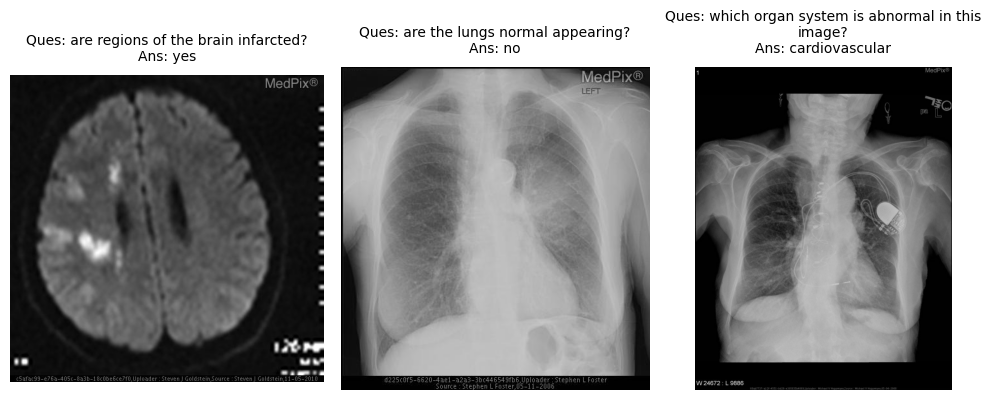

In [ ]:
dataset = load_dataset("flaviagiammarino/vqa-rad")
raw_train_data = dataset["train"]
raw_test_data = dataset["test"]

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    sample = raw_train_data[i]
    axes[i].imshow(sample["image"])
    axes[i].axis("off")
    wrapped_question = "\n".join(textwrap.wrap(sample['question'], width=40))
    axes[i].set_title(f"Ques: {wrapped_question}\nAns: {sample['answer']}", fontsize=10, pad=10)
plt.tight_layout()
plt.show()

In [ ]:
# Shuffle train split
full_train = raw_train_data.shuffle(seed=42)

# Split: 80% train, 20% validation
split = full_train.train_test_split(test_size=0.1, seed=42)
train_data = split["train"]
val_data = split["test"]
test_data = raw_test_data

print(train_data, val_data, test_data)

Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 1613
}) Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 180
}) Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 451
})


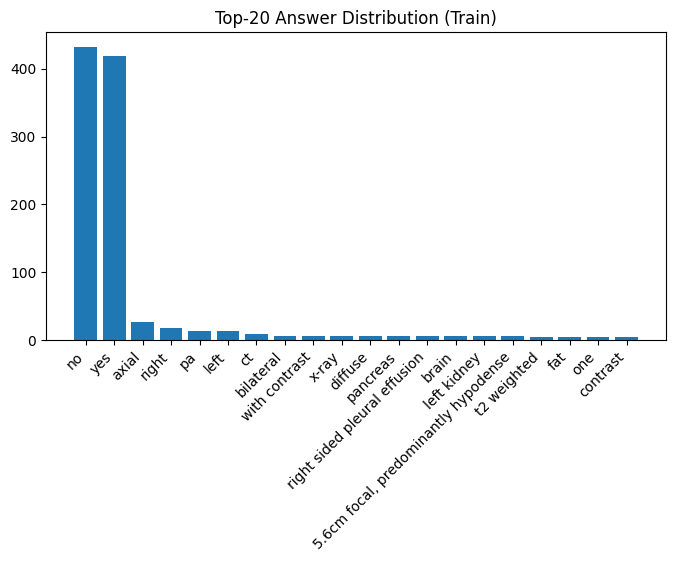

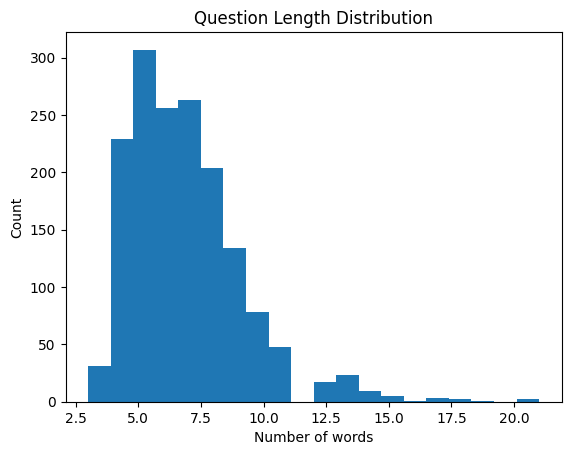

In [ ]:
# Answer distribution, identifies class imbalance
answer_counts = Counter(train_data["answer"])
top_answers = answer_counts.most_common(20)

labels, counts = zip(*top_answers)
plt.figure(figsize=(8,4))
plt.bar(labels, counts)
plt.xticks(rotation=45, ha="right")
plt.title("Top-20 Answer Distribution (Train)")
plt.show()

# Question length distribution, justifies token max length = 32
q_lens = [len(q.split()) for q in train_data["question"]]

plt.hist(q_lens, bins=20)
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.title("Question Length Distribution")
plt.show()


In [ ]:
# Filter out unseen answer label in val_data compared to train_data
train_answers = set(train_data["answer"])
val_answers = set(val_data["answer"])

unseen_answers = val_answers - train_answers

print(f"Unseen answers in validation ({len(unseen_answers)}):")
for a in sorted(unseen_answers):
    print(f"  - {a}")

Unseen answers in validation (19):
  - 12
  - almost entire right side
  - cancer
  - contrast in the intestines
  - emphysema
  - exterior
  - imaging artifacts
  - l2-3
  - less than half the thorax
  - midline
  - occipital lobe
  - pneumothorax
  - posterior brain
  - r hemidiaphragm
  - right vertebral artery sign
  - superficial to the patient's skin
  - superior
  - the pancreas
  - viral/inflammatory


In [ ]:
MIN_FREQ = 3
answer_counter = Counter(train_data["answer"])

# Answers to keep
kept_answers = {
    ans for ans, cnt in answer_counter.items()
    if cnt >= MIN_FREQ
}

print(f"Kept answers: {len(kept_answers)}")
print(f"Merged into <unk>: {len(answer_counter) - len(kept_answers)}")

le = LabelEncoder()
le.fit(list(kept_answers) + ["<unk>"])

# Save the Label Encoder
joblib.dump(le, 'label_encoder.joblib')
print("Label encoder has been saved!")

unk_label = le.transform(["<unk>"])[0]
num_classes = len(le.classes_)

print("num_classes:", num_classes)
print("unk_label:", unk_label)

def encode_answer(answer):
    if answer in kept_answers:
        return le.transform([answer])[0]
    else:
        return unk_label

train_ds = train_data.map(lambda x: {"label": encode_answer(x["answer"])})
val_ds   = val_data.map(lambda x: {"label": encode_answer(x["answer"])})
test_ds  = test_data.map(lambda x: {"label": encode_answer(x["answer"])})

def id2answer(idx):
    return le.inverse_transform([idx])[0]

Kept answers: 54
Merged into <unk>: 359
Label encoder has been saved!
num_classes: 55
unk_label: 2


Map:   0%|          | 0/1613 [00:00<?, ? examples/s]

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Map:   0%|          | 0/451 [00:00<?, ? examples/s]

In [ ]:
class VQARADDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        img = item["image"]
        # Instead of squashing, we add black borders to make it a square first.
        old_w, old_h = img.size
        max_dim = max(old_w, old_h)

        # Create a new black square image
        new_image = Image.new("RGB", (max_dim, max_dim), (0, 0, 0))

        # Paste the original image in the center
        paste_x = (max_dim - old_w) // 2
        paste_y = (max_dim - old_h) // 2
        new_image.paste(img, (paste_x, paste_y))

        # Now resize the SQUARE image to 224x224
        if self.transform:
            img = self.transform(new_image)
        else:
            img = new_image.resize((224, 224))
        question = item["question"]
        label = torch.tensor(item["label"], dtype=torch.long)
        return img, question, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure()
    plt.plot(epochs, train_losses)
    plt.plot(epochs, val_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend(["Train Loss", "Validation Loss"])
    plt.show()

def plot_accuracy(train_accs, val_accs):
    epochs = range(1, len(train_accs) + 1)

    plt.figure()
    plt.plot(epochs, train_accs)
    plt.plot(epochs, val_accs)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend(["Train Accuracy", "Validation Accuracy"])
    plt.show()

In [ ]:
def show_examples_pred(examples):
    n = len(examples)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1:
        axes = [axes]
    for ax, ex in zip(axes, examples):
        img = ex["image"].permute(1, 2, 0).clamp(0, 1)
        ax.imshow(img)
        ax.axis("off")
        wrapped_question = textwrap.fill(ex['ques'], width=40)
        ax.set_title(
            f"Ques: {wrapped_question}\n"
            f"Ans: {id2answer(ex['ans'])} | Pred: {id2answer(ex['pred'])}"
        )
    plt.tight_layout()
    plt.show()


In [ ]:
def eval_yes_no_and_open_ended(all_preds, all_labels):
    answers   = le.inverse_transform(all_labels)
    preds = le.inverse_transform(all_preds)

    yes_no_set = {"yes", "no"}

    yn_ans, yn_pred = [], []
    oe_ans, oe_pred = [], []

    for ans, pred in zip(answers, preds):
        ans = ans.lower().strip()
        pred = pred.lower().strip()

        if ans in yes_no_set:
            yn_ans.append(ans)
            yn_pred.append(pred)
        else:
            oe_ans.append(ans)
            oe_pred.append(pred)

    yn_acc = accuracy_score(yn_ans, yn_pred) if len(yn_ans) > 0 else 0.0
    oe_acc = accuracy_score(oe_ans, oe_pred) if len(oe_ans) > 0 else 0.0

    print(f"Yes/No Accuracy      : {yn_acc:.4f} ({len(yn_ans)} samples)")
    print(f"Open-ended Accuracy : {oe_acc:.4f} ({len(oe_ans)} samples)")

    if len(oe_ans) > 0:
        oe_f1 = f1_score(oe_ans, oe_pred, average="macro")
        print(f"Open-ended Macro-F1  : {oe_f1:.4f}")


# Part 2 - Baseline Model (Traditional NN) using CNN-LSTM

In [ ]:
def build_vocab(dataset, min_freq=2):
    counter = Counter()
    for q in dataset["question"]:
        counter.update(q.lower().split())  # simple word-level
    vocab = {word: idx+2 for idx, (word, freq) in enumerate(counter.items()) if freq >= min_freq}
    vocab["<pad>"] = 0
    vocab["<unk>"] = 1
    return vocab

vocab = build_vocab(train_data)
vocab_size = len(vocab)

def tokenize_question(text, vocab, max_len=32):
    # map unknown words to 0 (<unk>) and clip indices to vocab_size-1
    tokens = [vocab.get(w, vocab["<unk>"]) for w in text.lower().split()]
    tokens = [min(t, vocab_size-1) for t in tokens]  # <-- clamp to avoid out-of-range
    length = min(len(tokens), max_len)
    if len(tokens) < max_len:
        tokens += [vocab["<pad>"]] * (max_len - len(tokens))
    else:
        tokens = tokens[:max_len]
    return torch.tensor(tokens, dtype=torch.long), length

def collate_fn_lstm(batch):
    imgs, questions, labels = zip(*batch)
    imgs = torch.stack(imgs)
    # ensure all tokens are long and unknown words map to 0
    # q_tokens = torch.stack([tokenize_question(q, vocab) for q in questions]).long()
    tokenized = [tokenize_question(q, vocab) for q in questions]
    q_tokens = torch.stack([t[0] for t in tokenized])
    q_lengths = torch.tensor([t[1] for t in tokenized])

    labels = torch.stack(labels).long()
    return imgs, q_tokens, q_lengths, labels, questions


In [ ]:
# Save the LSTM Vocabulary
with open('vocab.json', 'w') as f:
    json.dump(vocab, f)
print("Vocabulary has been saved!")

Vocabulary has been saved!


In [ ]:
train_dataset = VQARADDataset(train_ds, transform=transform)
val_dataset   = VQARADDataset(val_ds, transform=transform)
test_dataset  = VQARADDataset(test_ds, transform=transform)

train_loader_lstm = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_lstm)
val_loader_lstm   = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_lstm)
test_loader_lstm  = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_lstm)


In [ ]:
class CNN_LSTM_VQA(nn.Module):
    def __init__(self, vocab_size, num_classes, embed_dim=256, hidden_dim=128, unfreeze_resnet=True):
        super().__init__()
        # Image feature extractor
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1) # 512 output features
        self.cnn.fc = nn.Identity()

        # Freeze CNN layers, only the final classifier and the img_norm layer will learn
        for p in self.cnn.parameters():
            p.requires_grad = False

        # Unfreeze the final block (layer4) that contains the most complex, high-level features
        if unfreeze_resnet:
            for p in self.cnn.layer4.parameters():
                p.requires_grad = True

        # Normalize to prevent the image modality from "overpowering" the text during the fusion step
        self.img_norm = nn.LayerNorm(512)

        # Question encoder
        self.embed = nn.Embedding(vocab_size, 256, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        # LSTM dropout prevents overfitting on tiny dataset
        # forces the model to understand the question even if it "misses" a few words
        self.q_dropout = nn.Dropout(0.3)

        # Fusion dropout prevents the final Linear layer from relying on a single specific "pattern" of image+text
        self.fusion_dropout = nn.Dropout(0.6)

        # Final classifier 512 (CNN) + 128 (LSTM) = 1024
        self.fc = nn.Linear(512 + hidden_dim, num_classes)

    def forward(self, img, q_tokens, q_lengths):
        img_feat = self.cnn(img)
        # Flatten (batch_size, 512, 1, 1) to (batch_size, 512)
        img_feat = torch.flatten(img_feat, 1)
        # Normalize
        img_feat = self.img_norm(img_feat)

        q_emb = self.embed(q_tokens)
        packed = nn.utils.rnn.pack_padded_sequence(
            q_emb, q_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        # We take the last layer hidden state of the LSTM
        _, (h, _) = self.lstm(packed)
        q_feat = h[-1]
        q_feat = self.q_dropout(q_feat)

        # Fuse the image features and text features
        combined = torch.cat([img_feat, q_feat], dim=1)
        combined = self.fusion_dropout(combined)
        return self.fc(combined)

In [ ]:
def evaluate_lstm(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, q_tokens, q_lengths, labels, *_ in loader:
            imgs, q_tokens, q_lengths, labels = imgs.to(device), q_tokens.to(device), q_lengths.to(device), labels.to(device)

            preds = model(imgs, q_tokens, q_lengths)
            loss = criterion(preds, labels)
            total_loss += loss.item()

            predicted = preds.argmax(dim=1)
            all_preds += predicted.cpu().tolist()
            all_labels += labels.cpu().tolist()

    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc, all_preds, all_labels


In [ ]:
# test
print(train_ds[0]['label'])  # should be <= num_classes-1
print("num_classes:", num_classes)
all_labels = [item['label'] for item in train_ds]
print("Max label:", max(all_labels))
print("Min label:", min(all_labels))
# Quick check for label range
for imgs, q_tokens, q_lengths, labels, _ in train_loader_lstm:
    print("Label range:", labels.min().item(), labels.max().item())
    print(imgs.shape, q_tokens.shape, q_lengths, labels)
    break

29
num_classes: 55
Max label: 54
Min label: 0
Label range: 2 54
torch.Size([16, 3, 224, 224]) torch.Size([16, 32]) tensor([ 6,  5,  5,  5,  4,  8,  7,  7, 13,  4,  5,  7,  5, 13,  5,  8]) tensor([29, 14,  2,  2, 33, 29, 32,  2, 30, 54, 54,  2, 29,  2, 34, 29])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


418487
No existing model found. Starting training...
Epoch 1/15 | Train Loss: 3.2268
Val Loss: 2.1119 | Val Acc: 0.4111
Epoch 2/15 | Train Loss: 2.1303
Val Loss: 1.9616 | Val Acc: 0.4167
Epoch 3/15 | Train Loss: 1.8197
Val Loss: 1.7616 | Val Acc: 0.5222
Epoch 4/15 | Train Loss: 1.5300
Val Loss: 1.5569 | Val Acc: 0.5556
Epoch 5/15 | Train Loss: 1.3350
Val Loss: 1.4453 | Val Acc: 0.6111
Epoch 6/15 | Train Loss: 1.2405
Val Loss: 1.5163 | Val Acc: 0.6056
Epoch 7/15 | Train Loss: 1.1921
Val Loss: 1.4400 | Val Acc: 0.6389
Epoch 8/15 | Train Loss: 1.1461
Val Loss: 1.4446 | Val Acc: 0.6444
Epoch 9/15 | Train Loss: 1.1286
Val Loss: 1.4561 | Val Acc: 0.6500
Epoch 10/15 | Train Loss: 1.0757
Val Loss: 1.4333 | Val Acc: 0.6667
Epoch 11/15 | Train Loss: 1.0373
Val Loss: 1.4137 | Val Acc: 0.6500
Epoch 12/15 | Train Loss: 1.0364
Val Loss: 1.3833 | Val Acc: 0.6500
Epoch 13/15 | Train Loss: 1.0109
Val Loss: 1.4198 | Val Acc: 0.6444
Early stopping triggered


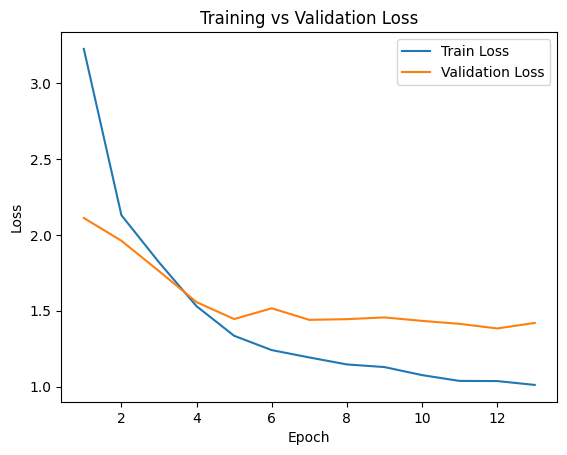

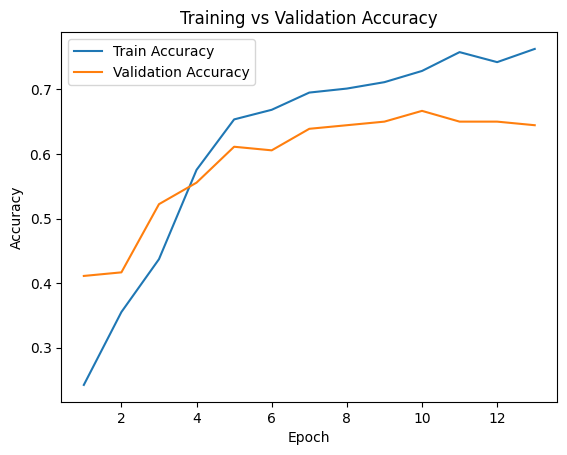

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "best_lstm.pth"
lstm_model = CNN_LSTM_VQA(vocab_size, num_classes, unfreeze_resnet=False).to(device)
# Print trainable parameters
print(sum(p.numel() for p in lstm_model.parameters() if p.requires_grad))
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

if os.path.exists(model_path):
    print(f"Found existing model at {model_path}. Loading weights and skipping training.")
    # map_location ensures it loads correctly even if trained on GPU and loaded on CPU
    lstm_model.load_state_dict(torch.load(model_path, map_location=device))
    lstm_model.eval()
    # Skip to evaluation or usage
    do_training = False
else:
    print("No existing model found. Starting training...")
    do_training = True

if do_training:
    optimizer = optim.AdamW([
        # {'params': lstm_model.cnn.layer4.parameters(), 'lr': 1e-5}, # Very small for CNN
        {'params': lstm_model.lstm.parameters(), 'lr': 3e-4},      # Normal for LSTM
        {'params': lstm_model.fc.parameters(), 'lr': 1e-3}        # Normal for Classifier
      ], weight_decay=1e-3)
    num_epochs = 15
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Early stopping variables
    best_val_acc = 0.0
    patience = 3
    counter = 0

    for epoch in range(num_epochs):
        lstm_model.train()
        total_loss = 0.0
        correct_pred = 0
        total_pred = 0

        # Training phase
        for imgs, q_tokens, q_lengths, labels, _ in train_loader_lstm:
            imgs = imgs.to(device)
            q_tokens = q_tokens.to(device)
            q_lengths = q_lengths.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            preds = lstm_model(imgs, q_tokens, q_lengths)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = preds.argmax(dim=1)
            correct_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)

        avg_loss = total_loss / len(train_loader_lstm)
        avg_acc = correct_pred / total_pred
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f}")

        # Evaluation phase
        val_loss, val_acc, _, _ = evaluate_lstm(lstm_model, val_loader_lstm, criterion, device)
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        train_losses.append(avg_loss)
        val_losses.append(val_loss)
        train_accs.append(avg_acc)
        val_accs.append(val_acc)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(lstm_model.state_dict(), "best_lstm.pth")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break

    plot_loss(train_losses, val_losses)
    plot_accuracy(train_accs, val_accs)

Test Loss: 1.6043 | Test Acc: 0.5565
Yes/No Accuracy      : 0.5657 (251 samples)
Open-ended Accuracy : 0.0806 (62 samples)
Open-ended Macro-F1  : 0.0520

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           2     0.7222    0.7536    0.7376       138
           3     0.0000    0.0000    0.0000         0
           5     0.5000    0.2500    0.3333        12
           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         1
           8     0.0000    0.0000    0.0000         5
          10     0.0000    0.0000    0.0000         0
          11     0.0000    0.0000    0.0000         0
          12     0.0000    0.0000    0.0000         0
          13     1.0000    0.3333    0.5000         3
          14     0.0000    0.0000    0.0000         0
          15     0.0000    0.0000    0.0000         0
          16     0.0000    0.0000    0.0000         2
          17

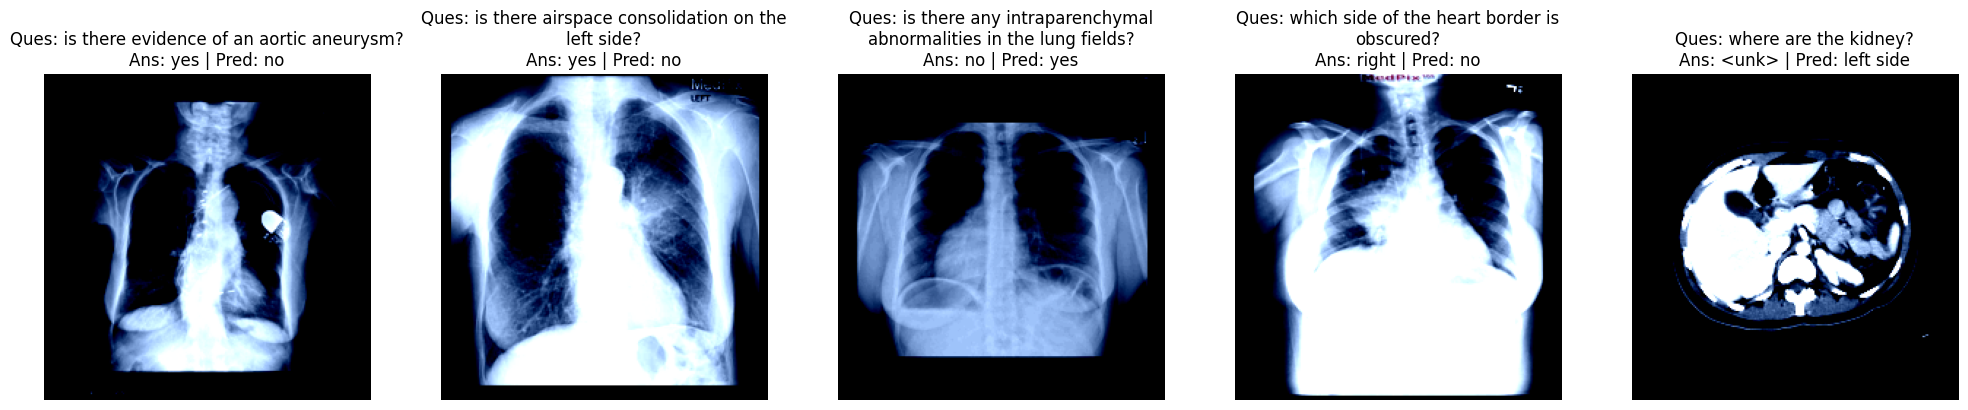

In [ ]:
# Testing phase
test_loss, test_acc, all_preds, all_labels = evaluate_lstm(lstm_model, test_loader_lstm, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

# Exclude <unk> from open-ended accuracy to avoid penalizing model for impossible answers
all_labels_np = np.array(all_labels)
all_preds_np  = np.array(all_preds)
mask = all_labels_np != unk_label #unknown_class
eval_yes_no_and_open_ended(all_preds_np[mask], all_labels_np[mask])

lstm_model.eval()
examples = []
with torch.no_grad():
    for imgs, q_tokens, q_lengths, labels, q_texts in test_loader_lstm:
        imgs, q_tokens, q_lengths, labels = imgs.to(device), q_tokens.to(device), q_lengths.to(device), labels.to(device)
        preds = lstm_model(imgs, q_tokens, q_lengths)
        predicted = preds.argmax(dim=1)

        # Save first few examples only
        for i in range(imgs.size(0)):
            if len(examples) >= 5:
                break
            examples.append({
                "image": imgs[i].cpu(),
                "ques": q_texts[i],
                "ans": labels[i].item(),
                "pred": predicted[i].item()
            })

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4, zero_division=0))

print("\nPrediction Examples:")
show_examples_pred(examples)

# Part 3 - Hybrid Model (Traditional NN + Transformer) using CNN-BERT

In [ ]:
# bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

def collate_fn_bert(batch):
    imgs, questions, labels = zip(*batch)
    imgs = torch.stack(imgs)

    enc = bert_tokenizer(
        list(questions),
        padding=True,
        truncation=True,
        max_length=32,
        return_tensors="pt"
    )

    labels = torch.stack(labels).long()
    return imgs, enc["input_ids"], enc["attention_mask"], labels, questions

vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [ ]:
train_dataset = VQARADDataset(train_ds, transform=transform)
val_dataset   = VQARADDataset(val_ds, transform=transform)
test_dataset  = VQARADDataset(test_ds, transform=transform)

train_loader_bert = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_bert)
val_loader_bert = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_bert)
test_loader_bert = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_bert)

In [ ]:
class CNN_BERT_VQA(nn.Module):
    def __init__(self, num_classes, unfreeze_resnet=True, unfreeze_bert=True):
        super().__init__()
        # Image feature extractor
        self.cnn = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1) # 2048 output features
        self.cnn.fc = nn.Identity()

        # Freeze CNN layers, only the final classifier and the img_norm layer will learn
        for p in self.cnn.parameters():
            p.requires_grad = False

        # Unfreeze the final block (layer4) that contains the most complex, high-level features
        if unfreeze_resnet:
            for p in self.cnn.layer4.parameters():
                p.requires_grad = True

        # Normalize to prevent the image modality from "overpowering" the text during the fusion step
        self.img_norm = nn.LayerNorm(2048)

        # BERT text encoder
        # self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.bert = BertModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

        # Freeze BERT layers
        for p in self.bert.parameters():
            p.requires_grad = False

        # Freeze BERT pooler (used for the [CLS] token summary)
        for param in self.bert.pooler.parameters():
                param.requires_grad = False

        if unfreeze_bert:
            # Unfreeze last few transformer blocks (e.g., Layer 11)
            # for i in range(11, 12):
            #     for param in self.bert.encoder.layer[i].parameters():
            #         param.requires_grad = True

            # Target Layer 11 specifically
            target_layer = self.bert.encoder.layer[11]

            for name, param in target_layer.named_parameters():
                # Unfreeze LayerNorm (very effective for domain shift)
                # Unfreeze all biases (helps shift the decision boundaries)
                if "LayerNorm" in name or "bias" in name:
                    param.requires_grad = True

        # BERT dropout
        self.text_dropout = nn.Dropout(0.3)

        # Fusion dropout
        self.fusion_dropout = nn.Dropout(0.6)

        # Final classifier 2048 (ResNet50) + 768 (BERT Pooler) = 2816
        self.classifier = nn.Linear(2048 + 768, num_classes)

    def forward(self, imgs, input_ids, attention_mask):
        img_feat = self.cnn(imgs)
        img_feat = torch.flatten(img_feat, 1)
        img_feat = self.img_norm(img_feat)

        bert_out = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Mean pooling over valid tokens
        last_hidden = bert_out.last_hidden_state  # (B, T, 768)
        mask = attention_mask.unsqueeze(-1)       # (B, T, 1)

        text_feat = (last_hidden * mask).sum(dim=1) / mask.sum(dim=1)
        text_feat = self.text_dropout(text_feat)

        combined = torch.cat([img_feat, text_feat], dim=1)
        combined = self.fusion_dropout(combined)
        return self.classifier(combined)

In [ ]:
def evaluate_bert(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, input_ids, attn_mask, labels, *_ in loader:
            imgs, input_ids, attn_mask, labels = imgs.to(device), input_ids.to(device), attn_mask.to(device), labels.to(device)

            preds = model(imgs, input_ids, attn_mask)
            loss = criterion(preds, labels)
            total_loss += loss.item()

            all_preds.extend(preds.argmax(dim=1).cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc, all_preds, all_labels


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 123MB/s]


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

No existing model found. Starting training...
159031


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch 1/15 | Train Loss: 2.6049
Val Loss: 2.0437 | Val Acc: 0.5111
Epoch 2/15 | Train Loss: 2.1339
Val Loss: 2.0737 | Val Acc: 0.5000
Epoch 3/15 | Train Loss: 1.9769
Val Loss: 1.9464 | Val Acc: 0.5778
Epoch 4/15 | Train Loss: 1.9250
Val Loss: 2.0212 | Val Acc: 0.5722
Epoch 5/15 | Train Loss: 1.9052
Val Loss: 1.9696 | Val Acc: 0.5833
Epoch 6/15 | Train Loss: 1.8993
Val Loss: 2.0077 | Val Acc: 0.5722
Epoch 7/15 | Train Loss: 1.8760
Val Loss: 2.0209 | Val Acc: 0.5778
Epoch 8/15 | Train Loss: 1.8172
Val Loss: 2.0221 | Val Acc: 0.6278
Epoch 9/15 | Train Loss: 1.8339
Val Loss: 2.0126 | Val Acc: 0.5833
Epoch 10/15 | Train Loss: 1.8294
Val Loss: 1.9428 | Val Acc: 0.6111
Epoch 11/15 | Train Loss: 1.8171
Val Loss: 1.9502 | Val Acc: 0.6111
Early stopping triggered


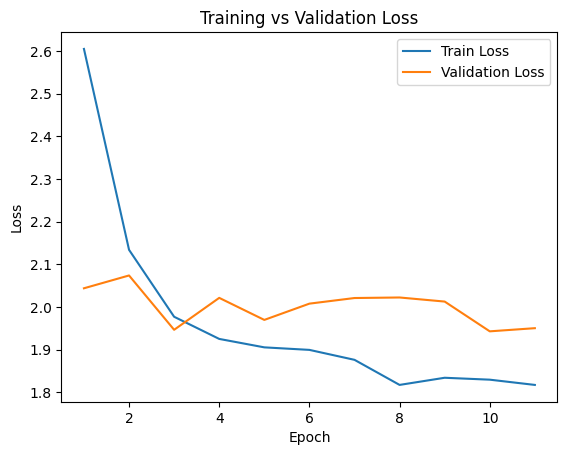

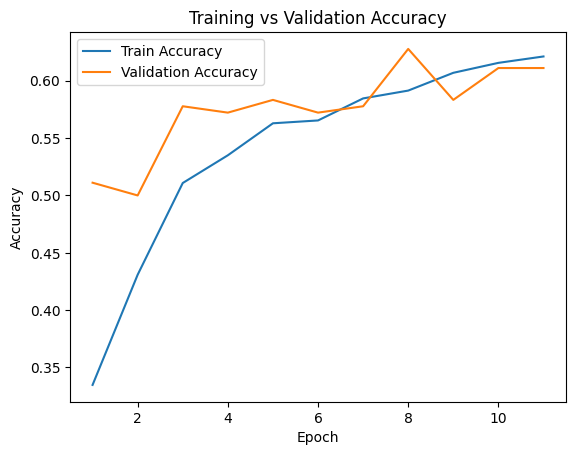

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = CNN_BERT_VQA(num_classes=num_classes, unfreeze_resnet=False, unfreeze_bert=False).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
model_path = "best_bert.pth"
if os.path.exists(model_path):
    print(f"Found existing model at {model_path}. Loading weights and skipping training.")
    # map_location ensures it loads correctly even if trained on GPU and loaded on CPU
    bert_model.load_state_dict(torch.load(model_path, map_location=device))
    bert_model.eval()
    # Skip to evaluation or usage
    do_training = False
else:
    print("No existing model found. Starting training...")
    do_training = True

if do_training:
    optimizer = optim.AdamW([
        {'params': bert_model.bert.parameters(), 'lr': 1e-5},      # Very slow for BERT
        {'params': bert_model.cnn.parameters(), 'lr': 0},         # Zero if still frozen
        {'params': bert_model.classifier.parameters(), 'lr': 1e-3} # Fast for new classifier
        ], weight_decay=1e-4)
    num_epochs = 15
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Early stopping variables
    best_val_acc = 0.0
    patience = 3
    counter = 0

    # Print trainable parameters
    print(sum(p.numel() for p in bert_model.parameters() if p.requires_grad))

    for epoch in range(num_epochs):
        bert_model.train()
        total_loss = 0
        correct_pred = 0
        total_pred = 0

        for imgs, input_ids, attn_mask, labels, *_ in train_loader_bert:
            imgs = imgs.to(device)
            input_ids = input_ids.to(device)
            attn_mask = attn_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            preds = bert_model(imgs, input_ids, attn_mask)
            loss = criterion(preds, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct_pred += (preds.argmax(dim=1) == labels).sum().item()
            total_pred += labels.size(0)

        avg_loss = total_loss / len(train_loader_bert)
        avg_acc = correct_pred / total_pred
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f}")

        # Validation phase
        val_loss, val_acc, _, _ = evaluate_bert(bert_model, val_loader_bert, criterion, device)
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        train_losses.append(avg_loss)
        val_losses.append(val_loss)
        train_accs.append(avg_acc)
        val_accs.append(val_acc)

        # Early Stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(bert_model.state_dict(), "best_bert.pth")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break

    plot_loss(train_losses, val_losses)
    plot_accuracy(train_accs, val_accs)

Test Loss: 2.3067 | Test Accuracy: 0.4900
Yes/No Accuracy      : 0.5498 (251 samples)
Open-ended Accuracy : 0.0323 (62 samples)
Open-ended Macro-F1  : 0.0107

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.0000    0.0000    0.0000         0
           2     0.6378    0.5870    0.6113       138
           3     0.0000    0.0000    0.0000         0
           4     0.0000    0.0000    0.0000         0
           5     0.4000    0.1667    0.2353        12
           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         1
           8     0.0000    0.0000    0.0000         5
           9     0.0000    0.0000    0.0000         0
          12     0.0000    0.0000    0.0000         0
          13     0.0000    0.0000    0.0000         3
          14     0.0000    0.0000    0.0000         0
          16     0.0000    0.0000    0.0000         2
       

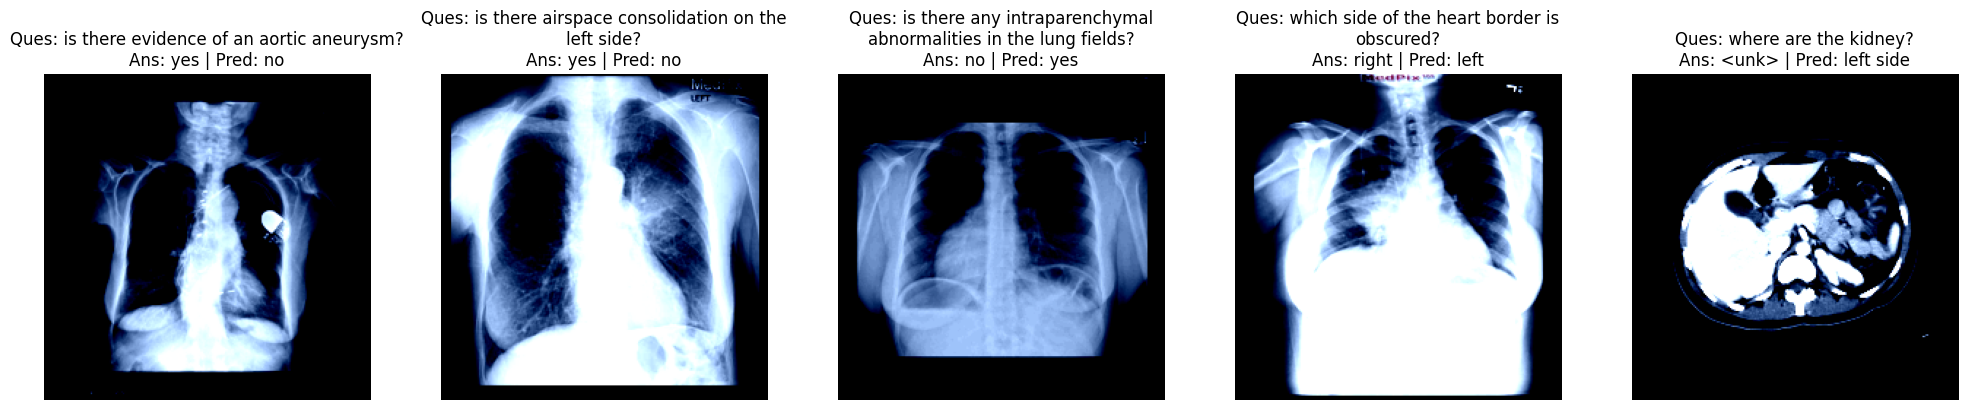

In [ ]:
# Testing phase
test_loss, test_acc, all_preds, all_labels = evaluate_bert(bert_model, test_loader_bert, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Exclude <unk> from open-ended accuracy to avoid penalizing model for impossible answers
all_labels_np = np.array(all_labels)
all_preds_np  = np.array(all_preds)
mask = all_labels_np != unk_label #unknown_class
eval_yes_no_and_open_ended(all_preds_np[mask], all_labels_np[mask])

bert_model.eval()
examples = []

with torch.no_grad():
    for imgs, input_ids, attn_mask, labels, q_texts in test_loader_bert:
        imgs = imgs.to(device)
        input_ids = input_ids.to(device)
        attn_mask = attn_mask.to(device)
        labels = labels.to(device)

        preds = bert_model(imgs, input_ids, attn_mask)
        predicted = preds.argmax(dim=1)

        # Save first few examples only
        for i in range(imgs.size(0)):
            if len(examples) >= 5:
                break
            examples.append({
                "image": imgs[i].cpu(),
                "ques": q_texts[i],
                "ans": labels[i].item(),
                "pred": predicted[i].item()
            })

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4, zero_division=0))

print("\nPrediction Examples:")
show_examples_pred(examples)

# Part 4 - Vision Language Model (Pure Transformer) using ViLT

In [ ]:
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def collate_fn_vilt(batch):
    imgs, questions, labels = zip(*batch)

    enc = processor(
        images=list(imgs),
        text=list(questions),
        padding=True,
        truncation=True,
        max_length=32,
        return_tensors="pt",
        do_rescale=False
    )

    # Ensure labels are integers instead of one-hot encoded to fit CrossEntropyLoss
    enc["labels"] = torch.tensor(labels, dtype=torch.long)
    return enc

In [ ]:
train_dataset_vilt = VQARADDataset(train_ds, transform=None)
val_dataset_vilt   = VQARADDataset(val_ds, transform=None)
test_dataset_vilt  = VQARADDataset(test_ds, transform=None)

train_loader_vilt = DataLoader(train_dataset_vilt, batch_size=16, shuffle=True, collate_fn=collate_fn_vilt)
val_loader_vilt   = DataLoader(val_dataset_vilt, batch_size=16, shuffle=False, collate_fn=collate_fn_vilt)
test_loader_vilt  = DataLoader(test_dataset_vilt, batch_size=16, shuffle=False, collate_fn=collate_fn_vilt)

In [ ]:
class ViltWithClassifierDropout(nn.Module):
    def __init__(self, num_classes, dropout_p=0.3):
        super().__init__()

        self.vilt = ViltForQuestionAnswering.from_pretrained(
            "dandelin/vilt-b32-finetuned-vqa",
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

        self.dropout = nn.Dropout(dropout_p)

    def forward(self, **batch):
        # IMPORTANT: remove labels so ViLT does NOT compute its own loss
        batch.pop("labels", None)

        outputs = self.vilt(**batch)
        logits = self.dropout(outputs.logits)
        return logits

In [ ]:
def evaluate_vilt(model, loader, device, criterion):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch.pop("labels")
            outputs = model(**batch)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            preds = outputs.logits.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc, all_preds, all_labels

In [ ]:
for batch in train_loader_vilt:
    print(batch["labels"].shape, batch["labels"].dtype)
    print(batch["labels"][:5])
    print(batch["pixel_values"].shape, batch["pixel_values"].dtype)
    print(batch["input_ids"].shape, batch["input_ids"].dtype)
    print(batch["attention_mask"].shape, batch["attention_mask"].dtype)
    break


torch.Size([16]) torch.int64
tensor([10, 54, 54,  2, 29])
torch.Size([16, 3, 384, 384]) torch.float32
torch.Size([16, 13]) torch.int64
torch.Size([16, 13]) torch.int64


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-finetuned-vqa and are newly initialized because the shapes did not match:
- classifier.3.weight: found shape torch.Size([3129, 1536]) in the checkpoint and torch.Size([55, 1536]) in the model instantiated
- classifier.3.bias: found shape torch.Size([3129]) in the checkpoint and torch.Size([55]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


No existing model found. Starting training...
1268791


model.safetensors:   0%|          | 0.00/470M [00:00<?, ?B/s]

Epoch [1/20] | Train Loss: 3.4108
Val Loss: 2.7786 | Val Acc: 0.4278
Epoch [2/20] | Train Loss: 2.3510
Val Loss: 2.0046 | Val Acc: 0.5722
Epoch [3/20] | Train Loss: 1.8818
Val Loss: 1.7209 | Val Acc: 0.6111
Epoch [4/20] | Train Loss: 1.7207
Val Loss: 1.6097 | Val Acc: 0.6389
Epoch [5/20] | Train Loss: 1.6455
Val Loss: 1.5497 | Val Acc: 0.6556
Epoch [6/20] | Train Loss: 1.5989
Val Loss: 1.5131 | Val Acc: 0.6556
Epoch [7/20] | Train Loss: 1.5585
Val Loss: 1.4823 | Val Acc: 0.6611
Epoch [8/20] | Train Loss: 1.5255
Val Loss: 1.4603 | Val Acc: 0.6667
Epoch [9/20] | Train Loss: 1.4978
Val Loss: 1.4401 | Val Acc: 0.6778
Epoch [10/20] | Train Loss: 1.4698
Val Loss: 1.4191 | Val Acc: 0.6667
Epoch [11/20] | Train Loss: 1.4447
Val Loss: 1.4049 | Val Acc: 0.6778
Epoch [12/20] | Train Loss: 1.4221
Val Loss: 1.3927 | Val Acc: 0.6833
Epoch [13/20] | Train Loss: 1.3991
Val Loss: 1.3832 | Val Acc: 0.6889
Epoch [14/20] | Train Loss: 1.3766
Val Loss: 1.3644 | Val Acc: 0.6944
Epoch [15/20] | Train Loss: 1

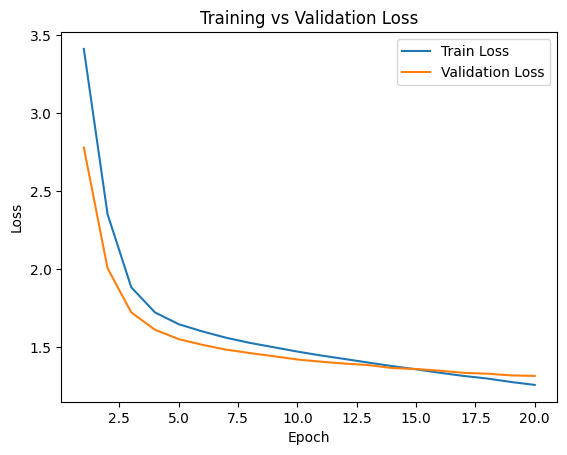

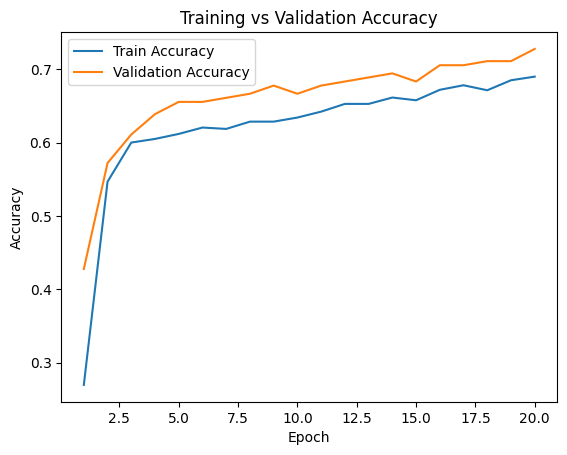

In [ ]:
# force CrossEntropyLoss using single_label_classification
vilt_model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa",
                                                      num_labels=num_classes,
                                                      ignore_mismatched_sizes=True,
                                                      problem_type="single_label_classification").to(device)

for name, param in vilt_model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
model_path = "best_vilt.pth"
if os.path.exists(model_path):
    print(f"Found existing model at {model_path}. Loading weights and skipping training.")
    # map_location ensures it loads correctly even if trained on GPU and loaded on CPU
    vilt_model.load_state_dict(torch.load(model_path, map_location=device))
    vilt_model.eval()
    # Skip to evaluation or usage
    do_training = False
else:
    print("No existing model found. Starting training...")
    do_training = True

if do_training:
    # apply lr to unfreeze layers only
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, vilt_model.parameters()), lr=3e-5, weight_decay=1e-4
    )
    num_epochs = 20
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Early stopping variables
    best_val_acc = 0.0
    patience = 3
    counter = 0

    # Print trainable parameters
    print(sum(p.numel() for p in vilt_model.parameters() if p.requires_grad))

    for epoch in range(num_epochs):
        vilt_model.train()
        total_loss = 0.0
        train_preds, train_labels = [], []

        for batch in train_loader_vilt:
            batch = {k: v.to(device) for k, v in batch.items()}

            # Do NOT pass labels to the model forward
            # outputs = vilt_model(**batch)
            # loss = outputs.loss
            labels = batch.pop("labels")  # remove from dict
            outputs = vilt_model(**batch)  # logits only
            logits = outputs.logits        # [B, num_classes]

            # Compute loss manually
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.logits.argmax(dim=1)

            train_preds.extend(preds.cpu().tolist())
            train_labels.extend(labels.cpu().tolist())

        avg_loss = total_loss / len(train_loader_vilt)
        avg_acc = accuracy_score(train_labels, train_preds)
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_loss:.4f}")

        # Validation phase
        val_loss, val_acc, _, _ = evaluate_vilt(vilt_model, val_loader_vilt, device, criterion)
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        train_losses.append(avg_loss)
        val_losses.append(val_loss)
        train_accs.append(avg_acc)
        val_accs.append(val_acc)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(vilt_model.state_dict(), "best_vilt.pth")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break

    plot_loss(train_losses, val_losses)
    plot_accuracy(train_accs, val_accs)

Test Loss: 1.2786 | Test Accuracy: 0.6275
Yes/No Accuracy      : 0.5418 (251 samples)
Open-ended Accuracy : 0.1935 (62 samples)
Open-ended Macro-F1  : 0.0631
Test Loss: 0.0441 | Test Accuracy: 0.6275

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           2     0.7377    0.9783    0.8411       138
           5     0.7778    0.5833    0.6667        12
           7     0.0000    0.0000    0.0000         1
           8     0.0000    0.0000    0.0000         5
          13     0.0000    0.0000    0.0000         3
          16     0.0000    0.0000    0.0000         2
          17     0.0000    0.0000    0.0000         1
          23     0.0000    0.0000    0.0000         2
          24     0.0000    0.0000    0.0000         6
          28     0.0000    0.0000    0.0000         4
          29     0.5674    0.6015    0.5839       133
          31     0.0000    0.0000    0.0000         3
          33     0.

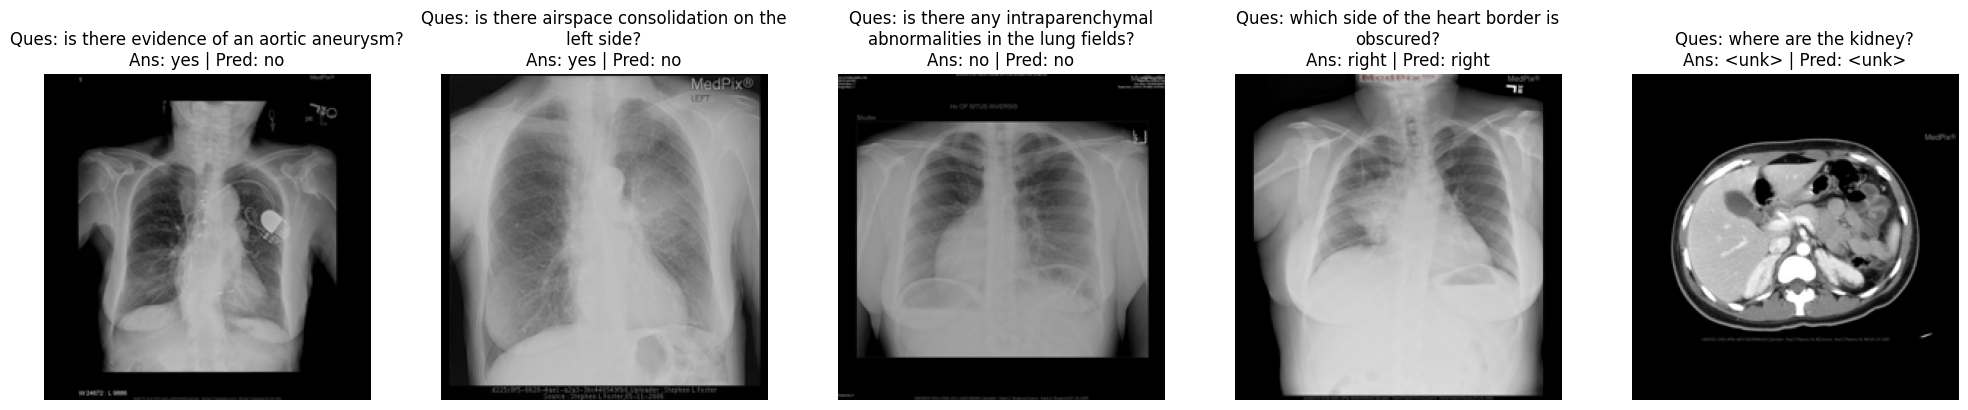

In [ ]:
# Testing phase
test_loss, test_acc, all_preds, all_labels = evaluate_vilt(vilt_model, test_loader_vilt, device, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Exclude <unk> from open-ended accuracy to avoid penalizing model for impossible answers
all_labels_np = np.array(all_labels)
all_preds_np  = np.array(all_preds)
mask = all_labels_np != unk_label #unknown_class
eval_yes_no_and_open_ended(all_preds_np[mask], all_labels_np[mask])

vilt_model.eval()
examples = []
sample_idx = 0

with torch.no_grad():
    for batch in test_loader_vilt:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch.pop("labels")
        outputs = vilt_model(**batch)
        preds = outputs.logits.argmax(dim=1)

        # Save first few examples only
        for i in range(preds.size(0)):
            if len(examples) >= 5:
                break
            original_img, original_ques, _ = test_dataset_vilt[sample_idx]
            examples.append({
                # "image": batch["pixel_values"][i].cpu(),
                "image": original_img,
                "input_ids": batch["input_ids"][i].cpu(),
                "ans": labels[i].item(),
                "pred": preds[i].item()
            })
            sample_idx += 1

test_loss /= len(test_loader_vilt)
test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4, zero_division=0))

print("\nPrediction Examples:")
n = len(examples)
fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))

if n == 1:
    axes = [axes]

for ax, ex in zip(axes, examples):
    # Image
    img = ex["image"]#.permute(1, 2, 0).clamp(0, 1)  # C,H,W → H,W,C
    ax.imshow(img)
    ax.axis("off")
    wrapped_question = textwrap.fill(processor.tokenizer.decode(ex['input_ids'], skip_special_tokens=True), width=40)
    ax.set_title(
        f"Ques: {wrapped_question}\n"
        f"Ans: {id2answer(ex['ans'])} | Pred: {id2answer(ex['pred'])}"
        # f"Ans: {le.inverse_transform([id2answer(ex['ans'])])[0]} | "
        # f"Pred: {le.inverse_transform([id2answer(ex['pred'])])[0]}"
    )

plt.tight_layout()
plt.show()